<a href="https://colab.research.google.com/github/ghinaalamsyahh/Fish-Recognizer/blob/main/Fish_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dataset dari kagglehub. Di sini, database yang dipakai: https://www.kaggle.com/datasets/markdaniellampa/fish-dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("markdaniellampa/fish-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/markdaniellampa/fish-dataset/versions/1


Import semua library yang diperlukan

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report

Membaca dataset dan membuat dataframe yang menggabungkan semua sampel data dari setiap kategori

In [ ]:
image_dir = Path(r'/root/.cache/kagglehub/datasets/markdaniellampa/fish-dataset/versions/1')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
category_samples = []
for category in images['Label'].unique():
    # Indented the lines within the for loop
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(
frac=1.0, random_state=1).reset_index(drop=True)

Hitung jumlah value untuk setiap label. Di sini ada 31 jenis ikan.

In [ ]:
image_df['Label'].value_counts()

,count
Label,
Long-Snouted Pipefish,100
Freshwater Eel,100
Glass Perchlet,100
Catfish,100
Bangus,100
Snakehead,100
Green Spotted Puffer,100
Indo-Pacific Tarpon,100
Gold Fish,100


Membagi dataset ke sesi training dan testing dengan rasio 70:30

In [ ]:
train_df, test_df = train_test_split(
image_df, train_size=0.7, shuffle=True, random_state=42)

train_generator dikonfigurasi untuk menghasilkan data pelatihan. Ini memproses gambar terlebih dahulu menggunakan fungsi prapemrosesan MobileNet V2 dan mengalokasikan 20% data untuk validasi (ditentukan oleh validation_split=0.2).

test_generator dikonfigurasi untuk menghasilkan data pengujian. Ini juga melakukan praproses gambar menggunakan fungsi prapemrosesan MobileNet V2 tetapi tidak membagi data untuk validasi, yang menyiratkan bahwa ini semata-mata untuk tujuan pengujian.

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

Sekarang kita akan menyiapkan tiga generator gambar untuk pelatihan, validasi, dan pengujian data menggunakan metode flow_from_dataframe yang disediakan oleh kelas ImageDataGenerator TensorFlow.

In [ ]:
train_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(224, 224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='training'
)
val_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(224, 224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='validation'
)
test_images = test_generator.flow_from_dataframe(
dataframe=test_df,
x_col='Filepath',
y_col='Label',
target_size=(224, 224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False
)

Found 1736 validated image filenames belonging to 31 classes.
Found 434 validated image filenames belonging to 31 classes.
Found 930 validated image filenames belonging to 31 classes.


Menggunakan MobileNetV2 untuk melatih model

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

model = MobileNetV2(weights='imagenet')
model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
input_shape=(224, 224, 3),
include_top=False,
weights='imagenet',
pooling='avg'
)
pretrained_model.trainable = False

Sekarang kita akan menambahkan layer padat tambahan di atas keluaran model MobileNetV2 yang telah dilatih sebelumnya dan membuat model baru yang sesuai untuk tugas klasifikasi tertentu.

In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(31, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,442,463 (9.32 MB)

 Trainable params: 184,479 (720.62 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Latih model. Epoch, dalam machine learning, mengacu pada keseluruhan penyampaian data pelatihan melalui algoritma. Semua data pelatihan digunakan sekaligus dan didefinisikan sebagai jumlah total iterasi semua data pelatihan dalam satu siklus untuk melatih model machine learning.

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True)])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.1688 - loss: 3.1146 - val_accuracy: 0.5369 - val_loss: 1.6578
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6495 - loss: 1.2536 - val_accuracy: 0.6475 - val_loss: 1.1817
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8181 - loss: 0.6631 - val_accuracy: 0.7396 - val_loss: 0.9074
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9119 - loss: 0.3679 - val_accuracy: 0.7719 - val_loss: 0.9026
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9548 - loss: 0.2371 - val_accuracy: 0.7465 - val_loss: 0.8882
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9779 - loss: 0.1388 - val_accuracy: 0.8041 - val_loss: 0.7820
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9966 - loss: 0.0798 - val_accuracy: 0.7857 - val_loss: 0.8422
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9963 - loss: 0.0484 - val_accuracy: 0.7995 - val_loss: 0.8076

Evaluasi model yang telah dibuat dan print tingkat akurasi dari testnya.

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 77.74%


Aplikasikan model yang telah dibuat terhadap gambar ikan yang ingin dicoba diidentifikasi.

Saving image20240725125740.webp to image20240725125740.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1


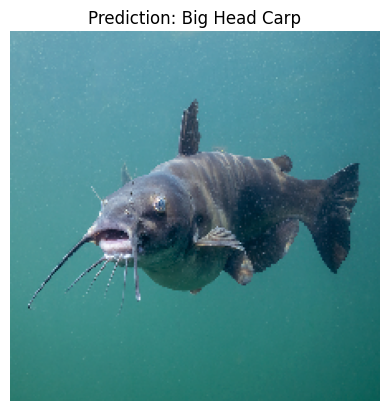

In [ ]:
from google.colab import files
import tensorflow as tf
import numpy as np
from PIL import Image

uploaded = files.upload()

# Get the unique labels from your training data
class_labels = list(train_images.class_indices.keys())

for fn in uploaded.keys():
  # predicting images
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(224, 224))
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
  preds = model.predict(x)
  print(np.argmax(preds)) # predicted class index

  # display the image and prediction
  plt.imshow(img)
  plt.axis('off')
  predicted_class = np.argmax(preds)

  # Use the class_labels derived from your training data
  predicted_class_label = class_labels[predicted_class]

  plt.title(f"Prediction: {predicted_class_label}")
  plt.show()